# Descriptive Analysis

Loading necessary libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
logging.basicConfig(
    level= logging.INFO,
    format= "%(asctime)s - %(levelname)s - %(message)s"
)

Loading the clean data from parquet files

In [2]:
anki: pd.DataFrame = pd.read_parquet("../data/clean_anki.parquet")
flowmodoro: pd.DataFrame = pd.read_parquet("../data/clean_flowmodoro.parquet")
bir: pd.DataFrame = pd.read_parquet("../data/clean_bir.parquet")
logging.info("Loadded parquet files into dataframes")

2025-11-18 15:58:05,668 - INFO - Loadded parquet files into dataframes


## Parameters

### Total time

In [3]:
total_mins_bir: float = bir.sum().sum()
total_hours_bir: float = round(total_mins_bir / 60, 2)
print(f"Total time spent studying for bir = {total_hours_bir}")

Total time spent studying for bir = 774.4


### Time spent by activity

In [4]:
total_by_act: pd.DataFrame = round(bir.sum() / 60, 1).reset_index()
total_by_act["activity"] = total_by_act["activity"].map({
    "01_own": "Anki",
    "active_recall": "Active Recall",
    "admin": "Admin",
    "anki_craft": "Anki Craft",
    "bhs": "BHS sys",
    "lectures": "Lectures",
    "exam_anki": "Exam Qs"
})
total_by_act = total_by_act.rename(columns={0: "time"})

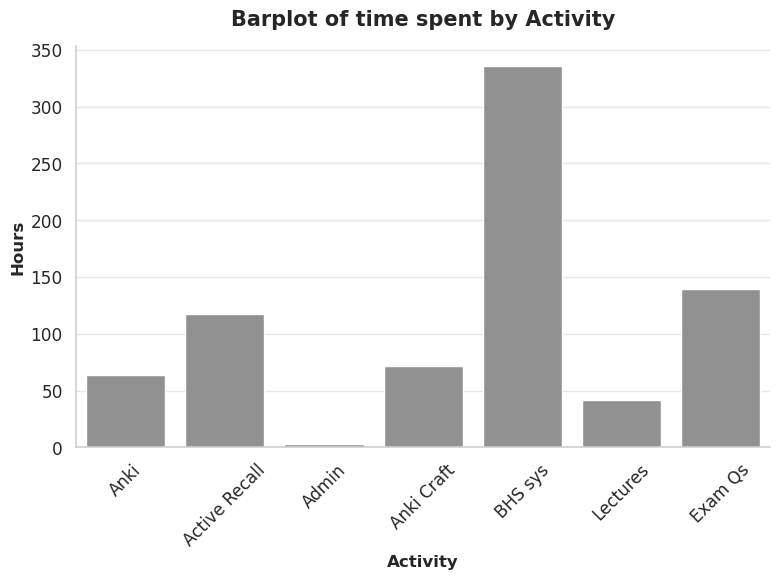

In [5]:
sns.set_theme(style="white", font_scale=1.1, rc={
    "axes.edgecolor": "0.8",
    "axes.linewidth": 1.1,
    "grid.color": "0.9",
    "axes.labelweight": "bold"
})

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=total_by_act,
    x="activity",
    y="time",
    color="#919191F1", 
    edgecolor=None
)

ax.set_xlabel("Activity", fontsize=12, weight='bold')
ax.set_ylabel("Hours", fontsize=12, weight='bold')
ax.set_title("Barplot of time spent by Activity", fontsize=15, weight='bold', pad=15)
ax.tick_params(axis='x', rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('0.8')
ax.spines['bottom'].set_color('0.8')
ax.grid(axis='y', color='0.9', linewidth=1)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.savefig("../images/barplot_time_activity.png", dpi=300, bbox_inches="tight")
plt.show()

### Daily mean vs median study time

First lets create a dataframe with the total time per day

In [8]:
bir_by_date: pd.DataFrame = bir.reset_index()
bir_by_date["date_day"] = pd.to_datetime(bir_by_date["date_day"])
bir_by_date["total_hours"] = bir_by_date.drop(columns="date_day").sum(axis=1)

### Efective study days

### Standard deviation of daily study time

### Highest and lowest single-day study time

### Most and least productive week